### Load Data

In [58]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob

In [59]:
methods = [
    "s3",
    "efs",
    "dynamodb",
    "redis",
    "relay",
    "p2p",
]

dfs = []

for method in methods:
  df = pd.concat([pd.read_json(f, lines=True) for f in glob.glob(f'../results/benchmark-personal/{method}-*.jsonl')], ignore_index=True)
  df['method'] = method
  dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [60]:
df.head(1)

,receiver_start_delay,total_time,message_size,sender_usage,receiver_usage,method
0,0.000288,0.125112,1000,"{'s3:PutObject': 1, 's3:GetObject': 3, 's3:Del...","{'s3:GetObject': 3, 's3:PutObject': 1, 's3:Del...",s3


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   receiver_start_delay  2300 non-null   float64
 1   total_time            2300 non-null   float64
 2   message_size          2300 non-null   int64  
 3   sender_usage          2300 non-null   object 
 4   receiver_usage        2300 non-null   object 
 5   method                2300 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 107.9+ KB


### Transformation & Cost calculation

In [62]:
# remove rows with receiver_start_delay > 0.01
df = df.query('receiver_start_delay < 0.01')

# subtract 1 from p2p latency
df.loc[df['method'] == 'p2p', 'total_time'] -= 1

# calculate latency
df['latency'] = df['total_time'] * 1000 / 2

# sum usage
def sum_usage(a, b):
    return {k: a.get(k, 0) + b.get(k, 0) for k in set(a) | set(b)}

df['usage'] = df.apply(
    lambda x: sum_usage(x['sender_usage'], x['receiver_usage']), axis=1
)

df['method'] = df['method'].map({
  's3': 'S3',
  'dynamodb': 'DynamoDB',
  'efs': 'EFS',
  'redis': 'Redis',
  'relay': 'Relay',
  'p2p': 'P2P',
})

# method as category
df['method'] = df['method'].astype('category')

# selected columns
df = df[['method', 'latency', 'message_size', 'usage']]

# rename columns
df = df.rename(columns={'message_size': 'size'})


In [63]:
keys = set()
for item in df.usage.tolist():
    keys.update(item.keys())
keys


# add keys to dataframe
for key in keys:
    df[key] = df.usage.apply(lambda x: x.get(key, 0))

df.head() 

# divide all keys by 2
for key in keys:
    df[key] = df[key] / 2

# remove usage column
df = df.drop(columns=['usage'])

df.head()

,method,latency,size,s3:DeleteObject,efs:write,dynamodb:DeleteItem,redis:get,efs:delete,s3:PutObject,efs:listdir,redis:delete,efs:read,redis:set,s3:GetObject,dynamodb:PutItem,dynamodb:GetItem
0,S3,62.556028,1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
1,S3,48.140764,1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0
2,S3,55.537343,1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3,S3,61.956167,1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0
4,S3,93.193293,1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0


In [64]:
PRICES = {
    "s3:GetObject": 0.0004 / 1000,
    "s3:PutObject": 0.005 / 1000,

    # per 4kb
    "dynamodb:GetItem": 0.25 / 1000000,
    "dynamodb:PutItem": 1.25 / 1000000,

    # per 4kb
    "efs:read": 0.03 / 1000 / 250,
    "efs:write": 0.06 / 1000 / 250,
    # per read (suppose it's less than 4kb)
    "efs:listdir": 0.03 / 1000 / 250,
}

In [65]:
# get one row of each method
df.groupby('method').first()


,latency,size,s3:DeleteObject,efs:write,dynamodb:DeleteItem,redis:get,efs:delete,s3:PutObject,efs:listdir,redis:delete,efs:read,redis:set,s3:GetObject,dynamodb:PutItem,dynamodb:GetItem
method,,,,,,,,,,,,,,,
DynamoDB,27.904034,10000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.5
EFS,17.173648,10000,0.0,1.0,0.0,0.0,1.0,0.0,3.5,0.0,1.0,0.0,0.0,0.0,0.0
P2P,5.474806,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Redis,2.831578,10000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
Relay,4.011393,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S3,62.556028,1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In [66]:
df['size_in_4kb_blocks'] = df['size'] / 4000
# ceil
df['size_in_4kb_blocks'] = df['size_in_4kb_blocks'].apply(np.ceil)

def multiply_calls_by_4kb_blocks(row):
  if row['dynamodb:PutItem'] != 0:
    row['dynamodb:PutItem'] *= row['size_in_4kb_blocks']
  
  if row['dynamodb:GetItem'] != 0:
    # Last read is full read
    row['dynamodb:GetItem'] = row['dynamodb:GetItem'] - 1 + row['size_in_4kb_blocks']

  if row['efs:read'] != 0:
    # Last read is full read
    row['efs:read'] = row['efs:read'] - 1 + row['size_in_4kb_blocks']

  if row['efs:write'] != 0:
    row['efs:write'] *= row['size_in_4kb_blocks']

  return row
    

df = df.apply(multiply_calls_by_4kb_blocks, axis=1)

df.sample(5)

,method,latency,size,s3:DeleteObject,efs:write,dynamodb:DeleteItem,redis:get,efs:delete,s3:PutObject,efs:listdir,redis:delete,efs:read,redis:set,s3:GetObject,dynamodb:PutItem,dynamodb:GetItem,size_in_4kb_blocks
1852,Relay,7.578731,100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
1808,Relay,6.731272,100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
576,EFS,16.268492,1,0.0,1.0,0.0,0.0,1.0,0.0,3.5,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2277,P2P,7.267237,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1769,Relay,3.829598,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [67]:
df['cost'] = df['efs:listdir'] * PRICES['efs:listdir'] + \
            df['efs:read'] * PRICES['efs:read'] + \
            df['efs:write'] * PRICES['efs:write'] + \
            df['dynamodb:PutItem'] * PRICES['dynamodb:PutItem'] + \
            df['dynamodb:GetItem'] * PRICES['dynamodb:GetItem'] + \
            df['s3:GetObject'] * PRICES['s3:GetObject'] + \
            df['s3:PutObject'] * PRICES['s3:PutObject']

In [68]:
df.head()

,method,latency,size,s3:DeleteObject,efs:write,dynamodb:DeleteItem,redis:get,efs:delete,s3:PutObject,efs:listdir,redis:delete,efs:read,redis:set,s3:GetObject,dynamodb:PutItem,dynamodb:GetItem,size_in_4kb_blocks,cost
0,S3,62.556028,1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.000006
1,S3,48.140764,1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,1.0,0.000006
2,S3,55.537343,1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.000006
3,S3,61.956167,1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,1.0,0.000006
4,S3,93.193293,1000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.000007


In [69]:
df = df[['method', 'latency', 'size', 'cost']]

In [70]:
# change size type to category
df['size'] = df['size'].astype('category')

# map size values
size_map = {
  1: '1B',
  1000: '1kB',
  10000: '10kB',
  100000: '100kB',
  1000000: '1MB',
  10000000: '10MB',
  100000000: '100MB',
  1000000000: '1GB',
}
df['size'] = df['size'].map(size_map)

df['cost_per_1m'] = df['cost'] * 1_000_000

df = df.drop(columns=['cost'])

In [71]:
PRICE_PER_GBS_OF_LAMBDA = 0.0000166667
GBS = 2

df['lambda_cost_per_1m'] = df['latency'] / 1000 * PRICE_PER_GBS_OF_LAMBDA * GBS * 1_000_000

df['total_cost_per_1m'] = df['lambda_cost_per_1m'] + df['cost_per_1m']

### Analysis

In [72]:
df.head()

,method,latency,size,cost_per_1m,lambda_cost_per_1m,total_cost_per_1m
0,S3,62.556028,1kB,6.2,2.085205,8.285205
1,S3,48.140764,1kB,6.0,1.604695,7.604695
2,S3,55.537343,1kB,6.2,1.851248,8.051248
3,S3,61.956167,1kB,6.4,2.065210,8.465210
4,S3,93.193293,1kB,7.4,3.106449,10.506449


In [73]:
# group by method and size
print("Average cost in USD and latency in ms per method and size.")
df.groupby(['method', 'size']).mean().style.format('{:.2f}').background_gradient(cmap='Blues')

Average cost in USD and latency in ms per method and size.


In [74]:
# print colors in matplotlib tab20
import matplotlib as mpl

# mpl.

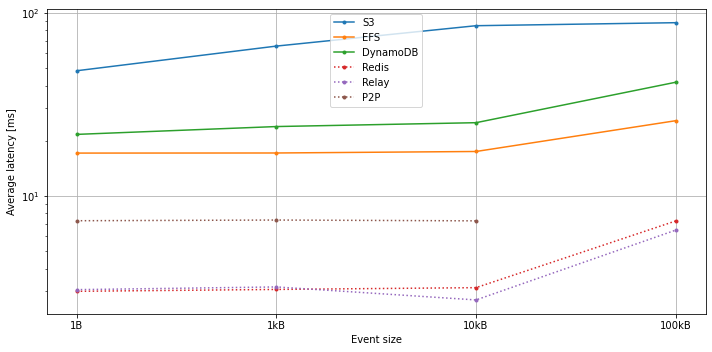

In [75]:
def plot_method(method, marker='x-'):
    ldf = df.query('method == @method').groupby('size').mean()
    plt.plot(ldf.index, ldf.latency, marker, label=method)


plt.figure(figsize=(10, 5))

plt.rcParams['font.family'] = 'Linux Libertine'
plt.rcParams['svg.fonttype'] = 'none'

plot_method('S3', '.-')
plot_method('EFS', '.-')
plot_method('DynamoDB', '.-')
plot_method('Redis', '.:')
plot_method('Relay', '.:')
plot_method('P2P', '.:')

plt.yscale('log')
plt.ylabel('Average latency [ms]')
plt.xlabel('Event size')
# plt.yticks([0.1, 1, 10, 100, 1000, 10_000], [
#            '$0.10', '$1', '$10', '$100', '$1000', '$10000'])
plt.legend()
plt.grid()


plt.tight_layout()

plt.savefig("img/latency-log.svg")


ValueError: min() arg is an empty sequence

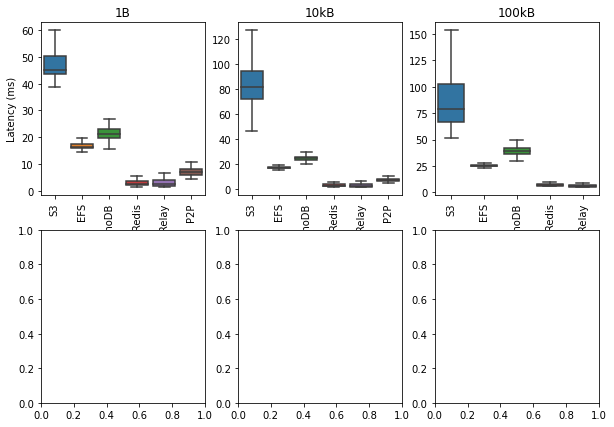

In [76]:
# ldf = df.query('method == "S3"')
# plt.boxplot(ldf.latency, positions=[1], widths=0.5)
# ldf = df.query('size == "1B"')
# sns.boxplot(data=ldf, x='method', y='latency')

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=False, sharey=False)

plt.rcParams['font.family'] = 'Linux Libertine'
plt.rcParams['svg.fonttype'] = 'none'

def do_plot(ax, size, left=False):
  sns.boxplot(data=df.query('size == @size'), x='method', y='latency', ax=ax, showfliers=False)
  ax.set_title(size)
  ax.set_xlabel(None)
  # ax.set_xticklabels(["1", "2", "3", "4", "5", "6"])
  if left:
    ax.set_ylabel("Latency (ms)")
  else:
    ax.set_ylabel(None)
  # rotate labels
  for tick in ax.get_xticklabels():
      tick.set_rotation(90)

do_plot(axs[0, 0], "1B", left=True)
do_plot(axs[0, 1], "10kB")
do_plot(axs[0, 2], "100kB")
do_plot(axs[1, 0], "1MB", left=True)
do_plot(axs[1, 1], "10MB")
do_plot(axs[1, 2], "100MB")

plt.tight_layout()

plt.savefig('img/latency.svg')

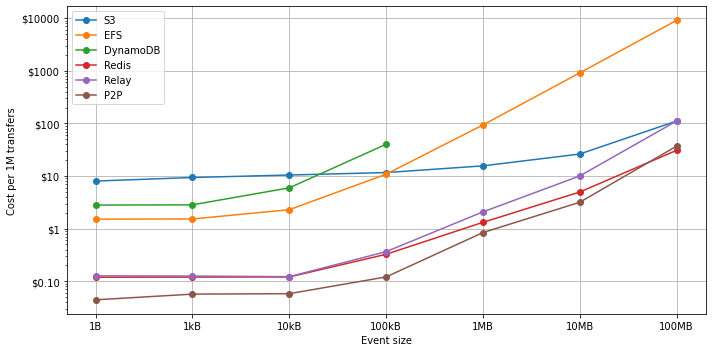

In [ ]:
def plot_method(method):
    ldf = df.query('method == @method').groupby('size').mean()
    plt.plot(ldf.index, ldf.total_cost_per_1m, 'o-', label=method)


plt.figure(figsize=(10, 5))

plt.rcParams['font.family'] = 'Linux Libertine'
plt.rcParams['svg.fonttype'] = 'none'

plot_method('S3')
plot_method('EFS')
plot_method('DynamoDB')
plot_method('Redis')
plot_method('Relay')
plot_method('P2P')

plt.yscale('log')
plt.ylabel('Cost per 1M transfers')
plt.xlabel('Event size')
plt.yticks([0.1, 1, 10, 100, 1000, 10_000], [
           '$0.10', '$1', '$10', '$100', '$1000', '$10000'])
plt.legend()
plt.grid()

# get bbox
plt.tight_layout()

plt.savefig("img/cost-1M-log.svg")


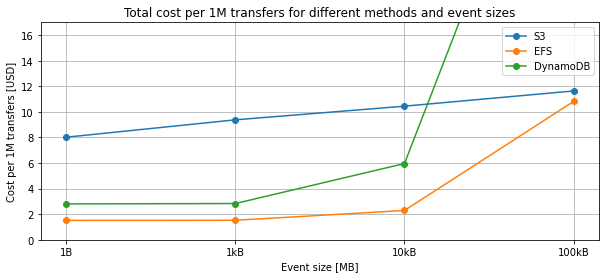

In [ ]:
def plot_method(method):
  ldf = df.query('method == @method and size in ["1B", "1kB", "10kB", "100kB"]').groupby('size').mean()
  plt.plot(ldf.index, ldf.total_cost_per_1m, 'o-', label=method)

plt.figure(figsize=(10, 4))

plot_method('S3')
plot_method('EFS')
plot_method('DynamoDB')

# plt.yscale('log')
plt.ylim(0, 17)
plt.ylabel('Cost per 1M transfers [USD]')
plt.xlabel('Event size [MB]')
plt.legend()
plt.title("Total cost per 1M transfers for different methods and event sizes")
plt.grid()


/var/folders/3d/y6js050d1wx3_6ltnsbp3znh0000gn/T/ipykernel_12921/2981927228.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ldf.index, rotation=-45)
/var/folders/3d/y6js050d1wx3_6ltnsbp3znh0000gn/T/ipykernel_12921/2981927228.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ldf.index, rotation=-45)
/var/folders/3d/y6js050d1wx3_6ltnsbp3znh0000gn/T/ipykernel_12921/2981927228.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ldf.index, rotation=-45)
/var/folders/3d/y6js050d1wx3_6ltnsbp3znh0000gn/T/ipykernel_12921/2981927228.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shoul

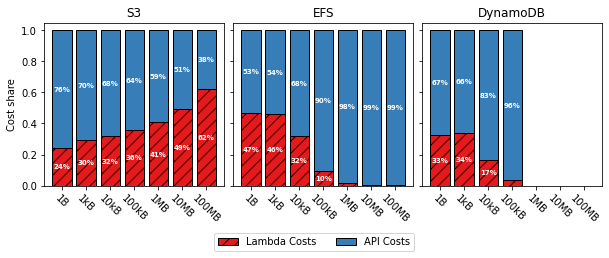

In [ ]:
def plot_method(ax, method):
    ldf = df.query('method == @method').groupby('size').mean()

    method_share = ldf.cost_per_1m/ldf.total_cost_per_1m
    lambda_share = ldf.lambda_cost_per_1m/ldf.total_cost_per_1m

    cmap = plt.get_cmap('Set1')

    ax.bar(ldf.index, lambda_share, label="Lambda Costs", width=0.8, hatch='//', edgecolor='black', color=cmap(0))
    # add labels inside bars
    for i, v in enumerate(lambda_share):
        if v < 0.05:
            continue
        ax.text(i, v/2, f"{v:.0%}", ha='center', va='center', color='white', fontweight='bold', fontsize=7)
    ax.bar(ldf.index, method_share, bottom=lambda_share, label="API Costs", width=0.8, hatch="", edgecolor='black', color=cmap(1))
    for i, v in enumerate(method_share):
        if v < 0.05:
            continue
        ax.text(i, v/2 + lambda_share[i], f"{v:.0%}", ha='center', va='center', color='white', fontweight='bold', fontsize=7)
    ax.set_xticklabels(ldf.index, rotation=-45)

plt.rcParams['font.family'] = 'Linux Libertine'
plt.rcParams['svg.fonttype'] = 'none'

# reduce spacing
# dont trim bottom
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace': 0.05})


plot_method(ax1, 'S3')
fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.20))
ax1.set_ylabel('Cost share')
ax1.set_title('S3')

plot_method(ax2, 'EFS')
ax2.set_title('EFS')

plot_method(ax3, 'DynamoDB')
ax3.set_title('DynamoDB')

plt.tight_layout()


plt.savefig("img/cost-share.svg")


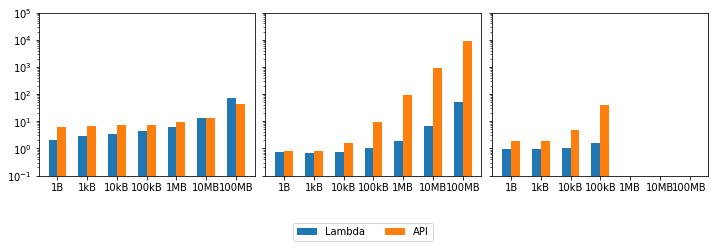

In [ ]:
def plot_method(ax, method):
    ldf = df.query('method == @method').groupby('size').mean()
    # use x position instead of index
    # map index to x position
    ax.bar(ldf.index.map(lambda x: ldf.index.get_loc(x) - 0.15), ldf.lambda_cost_per_1m, width=0.3, label="Lambda")
    ax.bar(ldf.index.map(lambda x: ldf.index.get_loc(x) + 0.15), ldf.cost_per_1m, width=0.3, label="API")
    ax.set_xticks(ldf.index.map(lambda x: ldf.index.get_loc(x)), ldf.index)

    # ax.bar(ldf.index, ldf.lambda_cost_per_1m, width=0.3, label="Lambda")
    # shift to the right
    # ax.bar(ldf.index + 0.3, ldf.cost_per_1m, width=0.3, label="EC2")


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

plt.rcParams['font.family'] = 'Linux Libertine'
plt.rcParams['svg.fonttype'] = 'none'

plot_method(ax1, 'S3')
fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.20))

# set yscale to log 
ax1.set_yscale('log')
ax1.set_ylim(0.1, 100000)
plot_method(ax2, 'EFS')
plot_method(ax3, 'DynamoDB')
# plot_method('Redis')
# plot_method('Relay')
# plot_method('P2P')


# plt.savefig("cost-1M-log.svg")


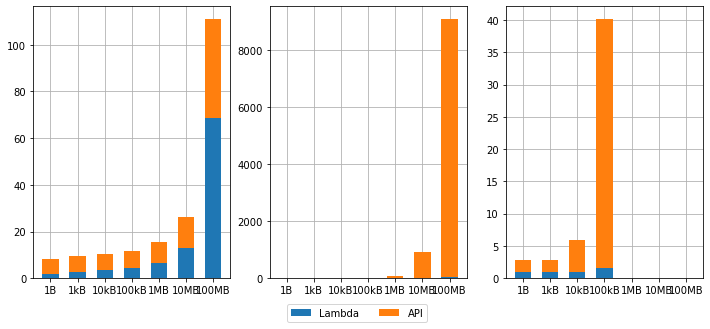

In [ ]:
def plot_method(ax, method):
    ldf = df.query('method == @method').groupby('size').mean()
    ax.grid(zorder=0)
    ax.bar(ldf.index, ldf.lambda_cost_per_1m, width=0.6, label="Lambda", zorder=3)
    ax.bar(ldf.index, ldf.cost_per_1m, width=0.6, bottom=ldf.lambda_cost_per_1m, label="API", zorder=3)
    ax.set_xticks(ldf.index.map(lambda x: ldf.index.get_loc(x)), ldf.index)



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=False)

plt.rcParams['font.family'] = 'Linux Libertine'
plt.rcParams['svg.fonttype'] = 'none'

plot_method(ax1, 'S3')
fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.01))

# set yscale to log 
plot_method(ax2, 'EFS')
plot_method(ax3, 'DynamoDB')
# plot_method('Redis')
# plot_method('Relay')
# plot_method('P2P')


# plt.savefig("cost-1M-log.svg")


### EC2 costs

In [ ]:
price_per_hour = 0.0052

requests_per_second = np.array([1, 10, 100])
print("Requests per second: ", requests_per_second)
requests_per_hour = requests_per_second * 60 * 60
print("Requests per hour: ", requests_per_hour)
hours_per_1m_requests = 1 / requests_per_hour * 1e6
print("Hours per 1m requests: ", hours_per_1m_requests)
price_per_1m_requests = hours_per_1m_requests * price_per_hour
print("Price per 1m requests: ", price_per_1m_requests)


Requests per second:  [  1  10 100]
Requests per hour:  [  3600  36000 360000]
Hours per 1m requests:  [277.77777778  27.77777778   2.77777778]
Price per 1m requests:  [1.44444444 0.14444444 0.01444444]
